In [34]:
import sys
from pathlib import Path

path_root = Path( '/project_ghent/HADSP/reservoirpy/')
sys.path.append(str(path_root))
path_root = Path( '/project_ghent/HADSP/hadsp/')
sys.path.append(str(path_root))

In [35]:
import numpy as np
from scipy import sparse

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

# Utility functions
from reservoir.utility import show_matrice, show_ei_matrix


# Reservoir functions

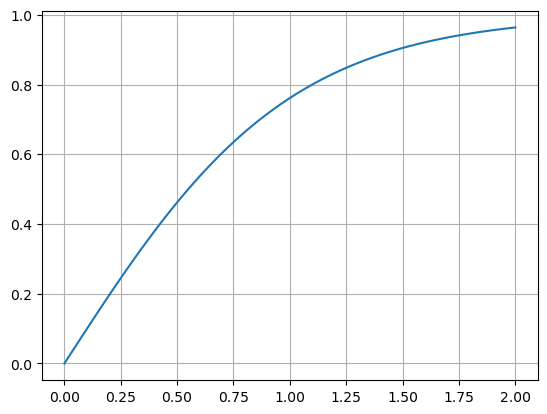

In [36]:
from importlib import reload
import reservoir.reservoir

from reservoir.reservoir import update_ei_reservoir, update_reservoir, ridge_regression, train, run
from reservoir.reservoir import synaptic_scaling, activation_target_definition, constant_synaptic_scaling
from reservoir.activation_functions import tanh, heaviside, sigmoid

reload(reservoir.reservoir)

# SEED
SEED = 3789

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 2, 100), activation_function(np.linspace(0, 2, 100)))
plt.grid()

In [37]:
from scipy import signal

# Apply a low-pass filter on with scipy.signal.filtfilt
def low_pass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff, btype='low', analog=False, fs=fs)
    return signal.filtfilt(b, a, data)

def high_pass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff, btype='high', analog=False, fs=fs)
    return signal.filtfilt(b, a, data)

def band_pass_filter(data, lowcut, highcut, fs, order=5):
    b, a = signal.butter(3, [lowcut, highcut], btype='band', fs=fs)
    return signal.filtfilt(b, a, data)


# Matrice initialization

https://www.nature.com/articles/s41598-018-22077-3
Based initialy on : 

    https://www.nature.com/articles/s41598-018-22077-3/tables/1
    N = 125 (12500 in the paper)
    Ratio of ne% = 0.8 -> ne = 100; ni% = 0.2  -> ni=25
    
    W_ei : Incoming excitatory connections per inhibitory neuron :10, with synaptic weight = 0.1mV
    W_ie : Incoming inhibitory connections per neuron :2,5, with synamtic weight : -0.8mV

In [38]:
from reservoir.reservoir import init_matrices

# Parameters
n_e = 100 # number of neurons for excitatory pool
n_i = 0 # number of neurons for inhibitory pool
SEED = 65718 # previous 3789
leaky_rate = 1

spectral_radius = 1
input_connectivity = 1
connectivity = 0.1 # from the article

# HYPERPARAMETERS
INCREMENT = 100
VALUE = 0.1
bias_scaling = 1
input_scaling = 0.1


# Initialisation EE
Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_e = Win_e*input_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)


<Axes: >

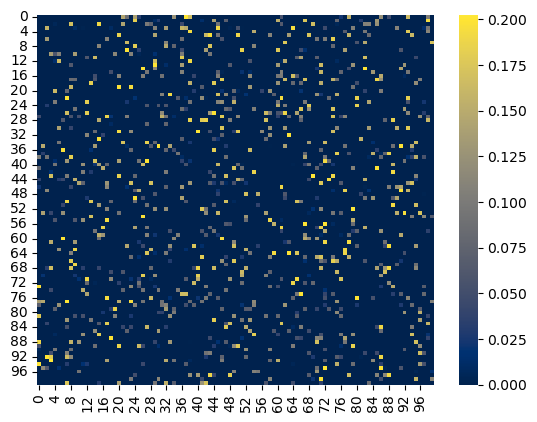

In [39]:
heatmap(W_ee.todense(), cmap=color_palette("cividis", as_cmap=True))

# Mackey Glass

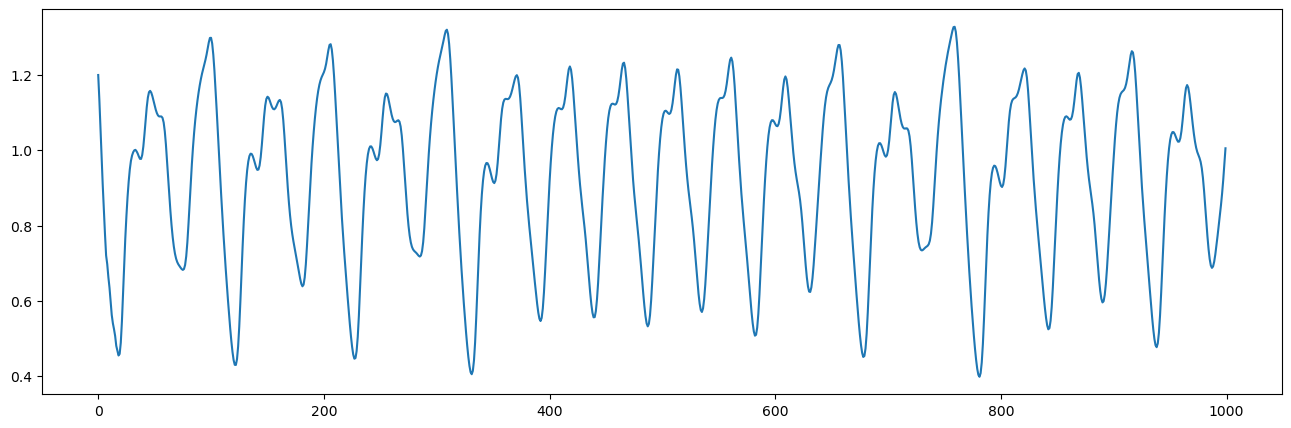

In [40]:
from reservoirpy.datasets import mackey_glass

timesteps = 10000
mg_inputs = mackey_glass(timesteps, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1, seed=None)

%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(range(1000), mg_inputs[:1000])
plt.show()

### Creating new outputs with band filters

In [41]:
from scipy.signal import butter, lfilter
from scipy.fft import fft

def butterworth_filter(data, lowcut, highcut, fs, btype='band', order=2):
    b, a = butter(order, [lowcut/(fs/2), highcut/(fs/2)], btype=btype)
    return lfilter(b, a, data).flatten()

# Define the time step of out Mackey-Glass system
dt = 1  # This is arbitraty

# Compute the equivalent sampling rate
sampling_rate = 1 / dt

from_paper = [
    [ 0.015, 0.02, 0.075],
    [ 0.001, 0.001, 0.0995],
    [ 0.05, 0.005, 0.15],
    [ 0.15, 0.1, 0.55]]

filtered_data = []
filtered_data.append(butterworth_filter(mg_inputs.flatten(), 0.00001, 0 + 0.01, fs=sampling_rate))
filtered_data.append(butterworth_filter(mg_inputs.flatten(), 0.04, 0.04 + 0.01, fs=sampling_rate))

for frequencies in from_paper:
    for f1 in np.arange(frequencies[0], frequencies[2]+frequencies[1], frequencies[1]):
        if f1 <= 0.05:
            f2 = f1 + 0.01
        else:
            f2 = f1 + 0.1
        try:
            filtered_data.append(butterworth_filter(mg_inputs.flatten(), f1, f2, fs=sampling_rate))
        except:
            print("fails" , f1)

filtered_data = np.array(filtered_data)
filtered_data[0, :] = filtered_data[0, :]*0.2 # separate input filtering so that the amplitude is similar to the other
# loop through frequency bands
# filtered_data = np.zeros((num_filters, len(mg_inputs)))
# for i in range(num_filters-1):
#     filtered_data[i, :] = butterworth_filter(mg_inputs.flatten(), cutoff_freqs[i], cutoff_freqs[i+1], fs=1)

fails 0.45000000000000007
fails 0.55


In [42]:
filtered_data.shape

(130, 10000)

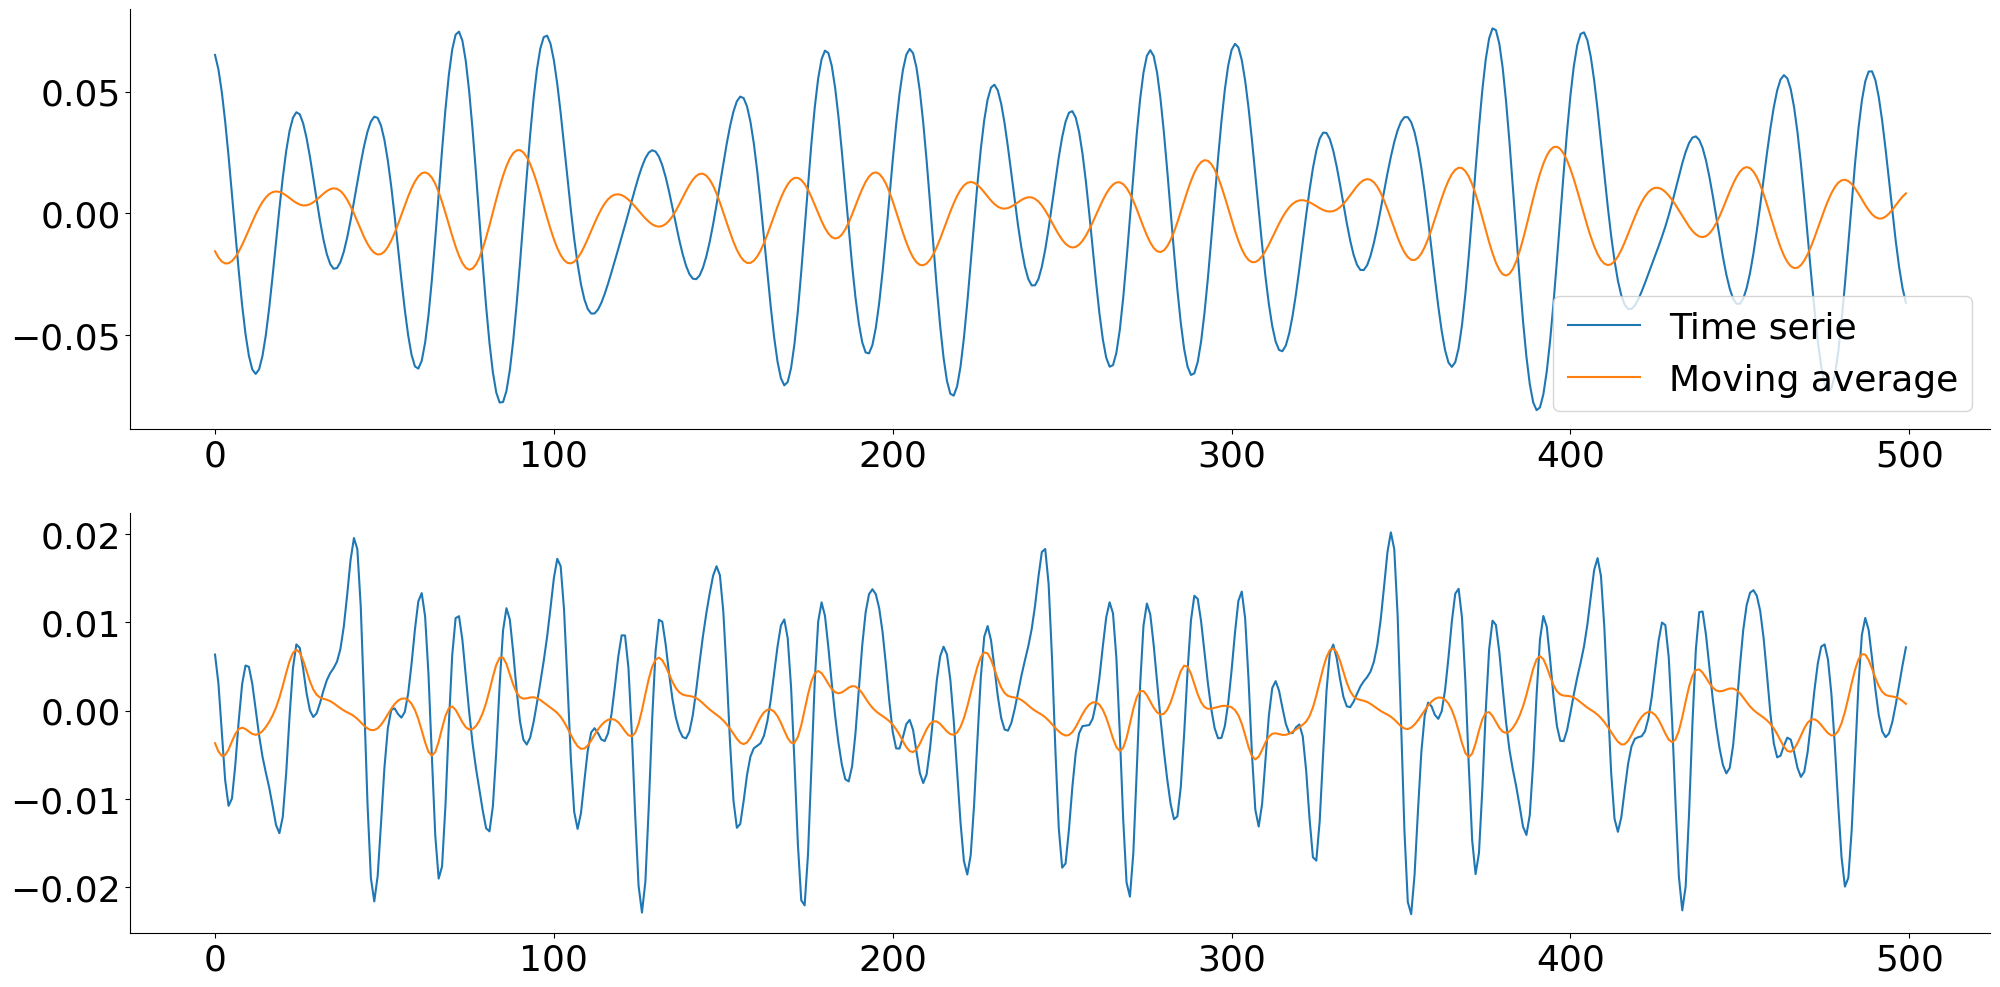

In [43]:

window_size = 20
weights = np.repeat(1.0, window_size)/window_size
ma = np.array([np.convolve(d, weights, 'valid') for d in (filtered_data)])

ax = plt.subplots(2, 1, figsize=(24,12))
ax[1][0].plot(range(500), filtered_data[3, 1000:1500], label='Time serie')
ax[1][0].plot(range(500), ma[3, 1000:1500], label='Moving average')
ax[1][0].legend(fontsize=26)
ax[1][1].plot(range(500), filtered_data[101, 1000:1500], label='Time serie')
ax[1][1].plot(range(500), ma[101, 1000:1500], label='Moving average')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][0].tick_params(axis='both', labelsize=26)
ax[1][1].tick_params(axis='both', labelsize=26)
plt.show()

In [44]:
frequency_bands = np.repeat(filtered_data, 2, axis=0)
print(frequency_bands.shape)

n = frequency_bands.shape[0]

(260, 10000)


## Creating from ADSP + bandfilter

In [45]:
import reservoir.reservoir
from reservoir.reservoir import update_reservoir
reload(reservoir.reservoir)

INCREMENT = 20
VALUE = 0.05

leaky_rate = 1
spectral_radius = 1
bias_scaling = 1
input_scaling = 1

target_rate = 0.8
growth_parameter = 0.1

# Initialisation EE
Win_e_hasp_band, W_ee_hasp_band, bias_hasp_band =  init_matrices(n, 1, 0, spectral_radius, seed=SEED)
bias_hasp_band = bias_hasp_band*bias_scaling
Win_e_hasp_band = Win_e_hasp_band*input_scaling


# last_state
state_e = np.random.uniform(0, 1, n)
step=0

state_history_e = []

total_add = 0
total_prun = 0
add = []
prun = []

/project_ghent/HADSP/hadsp/reservoir/reservoir.py:229: RuntimeWarning: divide by zero encountered in scalar divide
  W *= spectral_radius / sr


In [46]:
from connexion_generation.utility import compute_synaptic_change
from connexion_generation.bounded_adsp import bounded_adsp

for i in range(INCREMENT*5):
    state_e = update_reservoir(W_ee_hasp_band, Win_e_hasp_band, frequency_bands[:, i], state_e, leaky_rate, bias_hasp_band, activation_function)
    state_history_e.append(state_e)
frequency_bands = frequency_bands[:, INCREMENT * 5:]
train_length = len(frequency_bands[1,:])

while train_length > 5000:
    delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_hasp_band, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_hasp_band, state_e, delta_z_e, VALUE)

    for i in range(INCREMENT):
        state_e = update_reservoir(W_ee_hasp_band, Win_e_hasp_band, frequency_bands[:, i], state_e, leaky_rate, bias_hasp_band, activation_function)
        state_history_e.append(state_e)
    frequency_bands = frequency_bands[:, INCREMENT:]

    train_length = len(frequency_bands[1,:])
    
    total_add += nb_new_add_e
    total_prun += nb_new_prun_e
    add.append(total_add)
    prun.append(total_prun)

    step += 1
add = np.array(add)
prun = np.array(prun)

<Axes: >

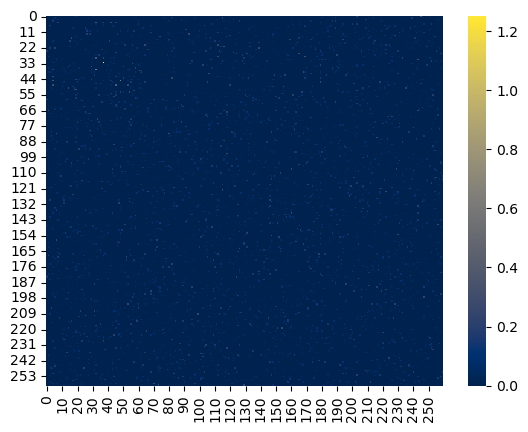

In [47]:
heatmap(W_ee_hasp_band.todense(), cmap=color_palette("cividis", as_cmap=True))

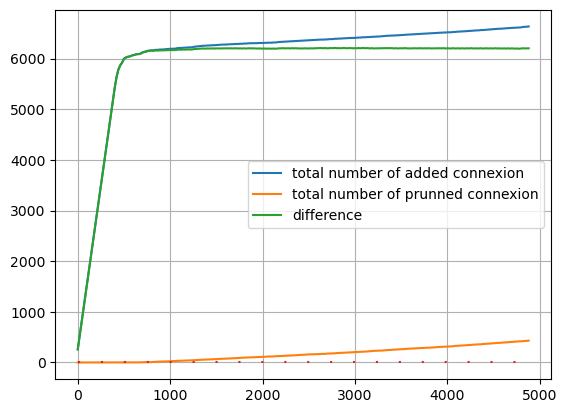

In [48]:
plt.figure()
plt.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
plt.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
plt.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
plt.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
plt.legend()
plt.grid()

## Creating matrice from ADSP+Mackey Glass

In [49]:
from reservoir.reservoir import update_reservoir
from reservoir.reservoir import init_matrices
from connexion_generation.bounded_adsp import bounded_adsp
from connexion_generation.utility import compute_synaptic_change

# Initialisation EE
Win_2, W_2, bias_2 =  init_matrices(n, 1, 0, spectral_radius, seed=SEED)
bias_2 = bias_2*bias_scaling
Win_2= Win_2*input_scaling

# initial state
state_4 = np.random.uniform(0, 1, n)


target_rate = 0.8 #  0.9 show good results as well
growth_parameter = 0.1

step=0
state_history_4 = []
total_added = 0
total_pruned = 0
add = []
prun = []

for i in range(INCREMENT*5):
    state_4 = update_reservoir(W_2, Win_2, mg_inputs[i], state_4, leaky_rate, bias_2, activation_function)
    state_history_4.append(state_4)
mg_inputs = mg_inputs[INCREMENT * 5:]


/project_ghent/HADSP/hadsp/reservoir/reservoir.py:229: RuntimeWarning: divide by zero encountered in scalar divide
  W *= spectral_radius / sr


In [50]:
train_length = len(mg_inputs[:])
while train_length > 5000:
    delta_z = compute_synaptic_change(state_history_4[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    W_2, _, nb_new_add, nb_new_prun = bounded_adsp(W_2, state_4, delta_z, VALUE)

    for i in range(INCREMENT):
        state_4 = update_reservoir(W_2, Win_2, mg_inputs[i], state_4, leaky_rate, bias_2, activation_function)
        state_history_4.append(state_4)
    mg_inputs = mg_inputs[INCREMENT:]

    train_length = len(mg_inputs[:])
    
    total_added += nb_new_add
    total_pruned += nb_new_prun
    add.append(total_added)
    prun.append(total_pruned)

    step += 1
add = np.array(add)
prun = np.array(prun)

<Axes: >

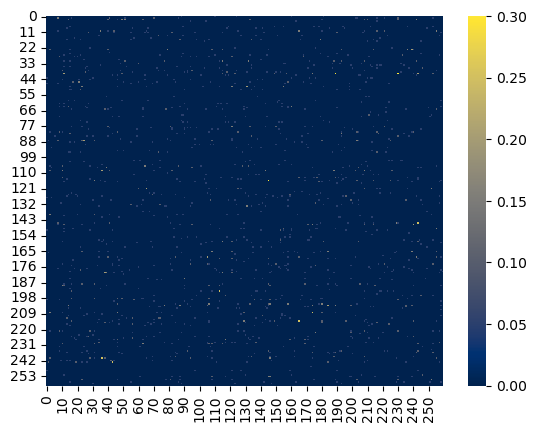

In [51]:
heatmap(W_2.todense(), cmap=color_palette("cividis", as_cmap=True))

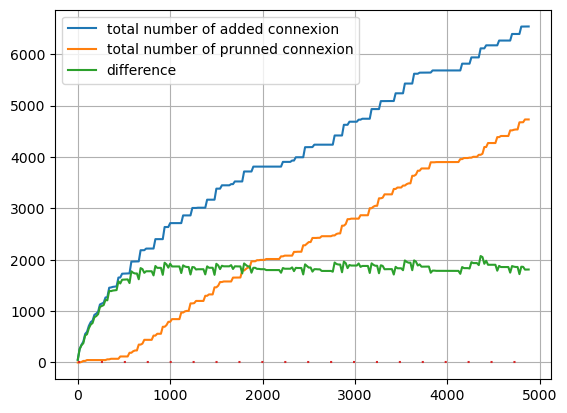

In [52]:
plt.figure()
plt.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
plt.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
plt.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
plt.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
plt.legend()
plt.grid()

## Other matrice

In [53]:
from scipy import stats

# We generate a network randomly with same spectral radius and same connectivity as the ADSP generated one
connectivity_mg =  W_ee_hasp_band.count_nonzero() / (W_ee_hasp_band.shape[0] * W_ee_hasp_band.shape[1])
eigen_adsp = sparse.linalg.eigs(W_ee_hasp_band, k=1, which="LM", maxiter=W_ee_hasp_band.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_adsp = max(abs(eigen_adsp))

# 3rd (normal + band)
Win_3, W_3, bias_3 =  init_matrices(n, 1, connectivity_mg, spectral_radius)
bias_3= bias_3*bias_scaling
Win_3= Win_3*0.3

eigen_3 = sparse.linalg.eigs(W_3, k=1, which="LM", maxiter=W_3.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_3 = max(abs(eigen_3))
W_3 = W_3*sr_adsp/sr_3
eigen_3 = sparse.linalg.eigs(W_3, k=1, which="LM", maxiter=W_3.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_3 = max(abs(eigen_3))

# 4th
connectivity_4 =  W_2.count_nonzero() / (W_2.shape[0] * W_2.shape[1])
eigen_4 = sparse.linalg.eigs(W_2, k=1, which="LM", maxiter=W_2.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_4 = max(abs(eigen_4))

# The normal matrice
Win_normal, W_normal, bias_normal =  init_matrices(n, 1, connectivity_mg, spectral_radius)
bias_normal= bias_normal*bias_scaling
Win_normal= Win_normal*0.3


eigen_normal = sparse.linalg.eigs(W_normal, k=1, which="LM", maxiter=W_normal.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_normal = max(abs(eigen_normal))
W_normal = W_normal*sr_4/sr_normal
eigen_normal = sparse.linalg.eigs(W_normal, k=1, which="LM", maxiter=W_normal.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_normal = max(abs(eigen_normal))


In [54]:
Win_normal

<260x1 sparse matrix of type '<class 'numpy.float64'>'
	with 260 stored elements in COOrdinate format>

In [55]:
print(sr_adsp)
print(sr_3)

print(sr_4)
print(sr_normal)


1.2285728501095423
1.2285728498289716
0.6288431385258005
0.6288431382636224


In [56]:
SR_NORMALIZED = 0.99
W_normal = W_normal*SR_NORMALIZED/sr_normal
W_ee_hasp_band = W_ee_hasp_band*SR_NORMALIZED/sr_adsp
W_3 = W_3*SR_NORMALIZED/sr_3
W_2 = W_2*SR_NORMALIZED/sr_4

## Performances

In [57]:
import reservoir.reservoir
from reservoir.reservoir import train_ei, train
reload(reservoir.reservoir)

ridge_coef = 1e-7
step_ahead = 1
# Training output
Wout_normal, b_out_normal, last_state_normal = train(W_normal, Win_normal, bias_normal, mg_inputs[:4000], mg_inputs[step_ahead:4000 + step_ahead], activation_function, ridge_coef = ridge_coef)

# Training output for HADSP + MG
Wout_2, b_out_2, last_state_2 = train(W_2, Win_2, bias_2, mg_inputs[:4000], mg_inputs[step_ahead:4000 + step_ahead], activation_function, ridge_coef = ridge_coef)

# Training output
Wout_3, b_out_3, last_state_3 = train(W_3, Win_3, bias_3, frequency_bands[:, :4000], mg_inputs[step_ahead:4000 + step_ahead], activation_function, ridge_coef = ridge_coef)

# Training output HASDP + bandfilter
Wout_hasp_band, b_out_hasp_band, last_state_hasp_band = train(W_ee_hasp_band, Win_e_hasp_band, bias_hasp_band, frequency_bands[:, :4000], mg_inputs[step_ahead:4000 + step_ahead], activation_function, ridge_coef = ridge_coef)



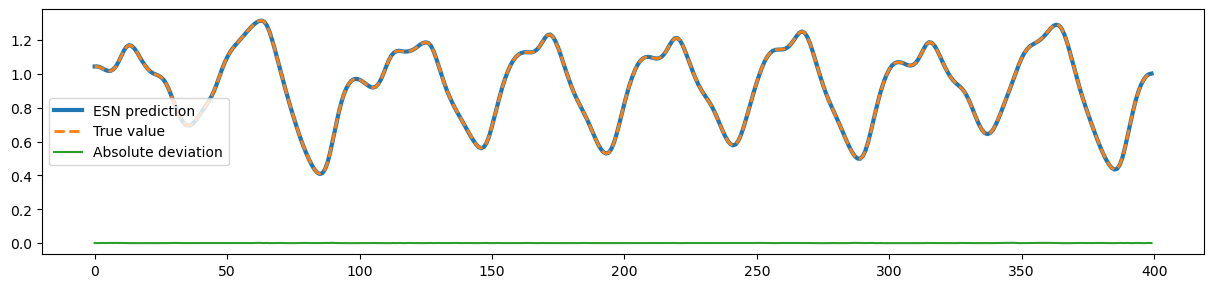

In [58]:
from reservoir.reservoir import run
reload(reservoir.reservoir)

from reservoir.reservoirpy_util import plot_results, plot_readout
np.zeros(2000)
frequency_bands[:,4000:5200]
mg_inputs[4000:5200]
# Prediction for random + MG
y_pred_normal = run(W_normal, Win_normal, bias_normal, Wout_normal, mg_inputs[4000:5200], activation_function, b_out_normal, last_state_normal)

# Prediction for HADSP + MG
y_pred_2 = run(W_2, Win_2, bias_2, Wout_2, mg_inputs[4000:5200], activation_function, b_out_2, last_state_2)

# Prediction for random + bandfilter
y_pred_3 = run(W_3, Win_3, bias_3, Wout_3, frequency_bands[:,4000:5200], activation_function, b_out_3, last_state_3)

# Prediction for HADSP + bandfilter
y_pred_hasp_band = run(W_ee_hasp_band, Win_e_hasp_band, bias_hasp_band, Wout_hasp_band, frequency_bands[:,4000:5200], activation_function, b_out_hasp_band, last_state_hasp_band)


plot_results(y_pred_3, mg_inputs[4000+step_ahead:], sample=400)


In [59]:
import reservoir.losses
from reservoir.losses import rmse, nrmse
reload(reservoir.losses)

y_target = mg_inputs[4000 + step_ahead :4300 + step_ahead]
print("nrmse normal        :", float(nrmse(y_target, y_pred_normal[:300])))
print("nrmse hadsp     :", float(nrmse(y_target, y_pred_2[:300])))
print("nrmse random + band :", float(nrmse(y_target, y_pred_3[:300])))
print("nrmse hadsp + band   :", float(nrmse(y_target, y_pred_hasp_band[:300])))


nrmse normal        : 0.007044804308296188
nrmse hadsp     : 0.015426264340123374
nrmse random + band : 0.0026638817541739294
nrmse hadsp + band   : 0.0018657080322002624


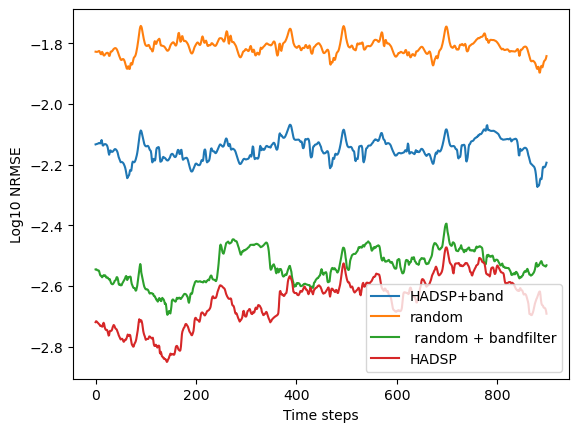

In [60]:
nrmse_array_normal = []
nrmse_array_2 = []
nrmse_array_3 = []
nrmse_array_mg = []

for i in range(len(y_pred_hasp_band)-100- step_ahead):
    y_target_i = mg_inputs[4000 + step_ahead +i: 4100 + step_ahead +i]
    nrmse_array_normal.append(nrmse(y_target_i, y_pred_normal[i:100+i]))
    nrmse_array_2.append(nrmse(y_target_i, y_pred_2[i:100+i]))
    nrmse_array_3.append(nrmse(y_target_i, y_pred_3[i:100+i]))
    nrmse_array_mg.append(nrmse(y_target_i, y_pred_hasp_band[i:100+i]))
    
log10_nrmse_normal = np.log10(nrmse_array_normal)
log10_nrmse_2 = np.log10(nrmse_array_2)
log10_nrmse_3 = np.log10(nrmse_array_3)
log10_nrmse_mg = np.log10(nrmse_array_mg)
plt.figure()
plt.plot(log10_nrmse_normal[:1000])
plt.plot(log10_nrmse_2[:1000])
plt.plot(log10_nrmse_3[:1000])
plt.plot(log10_nrmse_mg[:1000])

plt.xlabel('Time steps')
plt.ylabel('Log10 NRMSE')
plt.legend(["HADSP+band", "random", " random + bandfilter", "HADSP"])
plt.show()

In [61]:
# function to measure furthest predicted point based on RMSE
def furthest_predicted_point(y, y_pred, rmse_min):
    furthest_point = 0
    for i in range(len(y_pred)):
        rmse = np.sqrt(np.mean((y[i] - y_pred[i])**2))
        if rmse > rmse_min:
            furthest_point = i
    return furthest_point

# Analysis

In [62]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, permutations
from collections import defaultdict
from scipy.sparse import coo_matrix

def plot_connectivity(coo):
    G = nx.DiGraph()

    # Convert coo_matrix to edge list and add edges to the graph
    for node1, node2 in zip(coo.row, coo.col):
        G.add_edge(node1, node2)

    triad_connections = defaultdict(int)

    # Get all sets of 3 nodes
    for nodes in combinations(G.nodes, 3):
        # For each node in the triad, count its incoming and outgoing connections within the triad
        connectivity_states = []
        for node in nodes:
            in_edges = sum([G.has_edge(other, node) for other in nodes if other != node])
            out_edges = sum([G.has_edge(node, other) for other in nodes if other != node])
            connectivity_states.append((in_edges, out_edges))
        # Sort the connectivity states so that equivalent triads have the same key, regardless of node order
        connectivity_states = tuple(sorted(connectivity_states))
        triad_connections[connectivity_states] += 1

    # Sort results by total number of connections
    sorted_results = sorted(((sum(value for in_out in key for value in in_out), key) for key in triad_connections.items()), key=lambda x: x[0])
    sorted_labels = [str(key) for total, key in sorted_results]
    sorted_values = [triad_connections[key] for total, key in sorted_results]

    # Plot results
    plt.bar(range(len(sorted_labels)), sorted_values, tick_label=sorted_labels)
    plt.xlabel('Triad connectivity state')
    plt.ylabel('Count')
    plt.title('Triad Connection Count in Graph')
    plt.xticks(rotation=90)
    plt.show()


plot_connectivity(W_normal)

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [ ]:
plot_connectivity(W_ee_hasp_band)

In [ ]:
from joblib import Parallel, delayed
from sklearn.metrics import mutual_info_score
import numpy as np
from tqdm import tqdm

time_series = filtered_data
# Create a matrix to hold the mutual information between each pair of time series
mi_matrix = np.zeros((len(time_series), len(time_series)))

    
# Function to compute mutual information
def compute_mi(i, j):
    # Discretize the data
    time_series_i_discrete = np.floor(time_series[i] * 10).astype(int)
    time_series_j_discrete = np.floor(time_series[j] * 10).astype(int)
    
    # Compute mutual information
    mi = mutual_info_score(time_series_i_discrete, time_series_j_discrete)
    
    return i, j, mi

# Create a list of all pairs of indices
indices = [(i, j) for i in range(len(time_series)) for j in range(i, len(time_series))]



# Use joblib to parallelize the computation
results = Parallel(n_jobs=-1, backend="threading", verbose=1)(delayed(compute_mi)(i, j) for i, j in indices)

# Store the results in the matrix
for i, j, mi in results:
    mi_matrix[i, j] = mi
    mi_matrix[j, i] = mi

pbar.close()

heatmap(mi_matrix)